# Import of libraries and data sets

In [1]:
from feature_extraction import *
from nice_plots import *
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [2]:
# import data set
df = pd.read_csv("train.csv")
test_df =  pd.read_csv("test.csv")

Our setup : we have for 663 observations, in different potions and different observation times, 24 devices recording measurements in the form of timeseries of length 2048.

In [6]:
# have a look
df

,id,main.pos,fun.pos,when,y,E1A1,E1A2,E1A3,E1A4,E1A5,...,M2V2039,M2V2040,M2V2041,M2V2042,M2V2043,M2V2044,M2V2045,M2V2046,M2V2047,M2V2048
0,1,LHCB-P18,QSCB-18-C2,2017-06,1,-0.576589,-0.951065,0.944338,-0.086406,0.253089,...,-0.017011,-0.101842,0.027109,0.168339,0.152390,0.000410,-0.126250,0.072403,0.214993,0.184996
1,2,LHCB-6,QSCB-6-CP6,2018-09,1,0.970694,1.524991,1.813341,0.447012,-1.038631,...,0.106717,-0.057328,-0.146602,0.069251,0.351492,0.106101,0.192691,0.167834,-0.170475,-0.236751
2,3,LHCB-8,QSCB-8-CP7,2022-11,1,1.065262,0.461292,0.416869,0.460564,-0.019386,...,0.198017,-0.044788,0.011786,-0.037881,-0.152690,-0.104267,0.037444,0.489454,0.268134,-0.117367
3,4,LHCB-8,QSCB-8-CP1,2023-04,1,-0.341942,0.614190,0.904430,0.727268,0.187494,...,0.168140,-0.071131,0.067982,-0.023509,-0.028273,0.000943,-0.018128,0.013366,0.015902,0.043247
4,5,LHCB-P18,QSCB-18-C1,2017-04,1,-0.569563,0.368497,-0.269832,-0.179988,-0.065328,...,0.082521,0.105978,0.020868,0.173724,-0.037431,0.147695,0.038233,-0.047549,0.101227,-0.109760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,1012,LHCB-4,QSCB-4-CP1,2019-03,1,-0.094653,-0.273495,0.927676,-0.244089,0.394102,...,0.076421,-0.017458,0.113222,0.081531,-0.118022,-0.068159,-0.160683,-0.054098,-0.043842,0.079474
659,1013,LHCB-6,QSCB-6-CP1,2022-05,1,-0.447106,-0.074231,0.331543,0.150676,-0.050445,...,0.137185,0.240015,0.169615,0.068595,0.097196,-0.020113,-0.010522,0.063634,0.096408,-0.085637
660,1014,LHCB-P18,QSCB-18-C2,2018-04,1,0.264532,1.554129,-1.447155,0.442756,2.655931,...,-0.037920,0.087096,-0.399536,-0.121802,-0.027615,-0.190010,-0.099357,-0.026138,-0.008852,-0.108788
661,1015,LHCB-4,QSCB-4-CP7,2017-01,1,-0.522473,-0.007026,0.361770,-0.630256,-0.851504,...,-0.256542,-0.215720,-0.006428,0.037543,0.120194,0.155707,0.156359,0.280801,0.155129,0.176686


# Functions for feature extraction

### Max power spectrum (FFT)

The **Fast Fourier Transform (FFT)** is an efficient algorithm used to compute the Discrete Fourier Transform (DFT) of a signal. The DFT is a mathematical transformation that converts a time-domain signal into its frequency-domain representation. In simpler terms, the FFT converts a signal from the time domain to the frequency domain, providing information about the various frequencies present in the signal.

Mathematically, for a time series $\{x[n]\}$ of length N, the DFT is defined as:

$X[k] = \sum {x[n] * exp(-j * 2 * \pi * k * n / N)}$

where $X[k]$ is the complex-valued representation of the signal at frequency bin k (ranging from 0 to N-1), and j is the imaginary unit.

The FFT algorithm significantly speeds up the computation of the DFT by exploiting symmetries and reducing the number of computations required, making it practical for real-world applications.

Now, let's explore why the Fast Fourier Transform can be useful in anomaly detection:

1. Frequency Analysis: The FFT provides a frequency representation of the signal, highlighting the presence and magnitude of different frequency components. Anomalies might be characterized by unusual or unexpected frequencies in the signal.

2. Spectral Leakage: When analyzing periodic signals or events with a specific frequency, the FFT can show clear spikes or peaks at the corresponding frequency bins. Spectral leakage (a phenomenon in FFT) might cause the energy from a frequency to spread to neighboring bins. Detecting such energy spread can help in identifying potential anomalies.

3. Detecting Unexpected Frequencies: Anomalies may introduce new frequencies not present in the normal behavior. By observing significant energy spikes at unusual frequencies, you can detect deviations from the expected patterns.

4. Frequency Trends: FFT can help detect trends in the frequency domain, such as a gradual increase or decrease in certain frequency components, which may indicate a change in the system's behavior.

5. Noise Analysis: In some cases, anomalies can manifest as noise or interference in the signal. FFT can help distinguish between the noise and meaningful frequency components, making it easier to detect anomalies.

6. Feature Extraction: In many anomaly detection algorithms, the FFT is used as a preprocessing step to extract frequency-domain features. These features can be fed into machine learning models or anomaly detection algorithms for classification and anomaly identification.

7. Comparison with Normal Behavior: By analyzing the FFT of the signal during normal operation, you can establish a baseline or reference for the expected frequency distribution. During anomaly detection, any deviation from this baseline can be considered an anomaly.

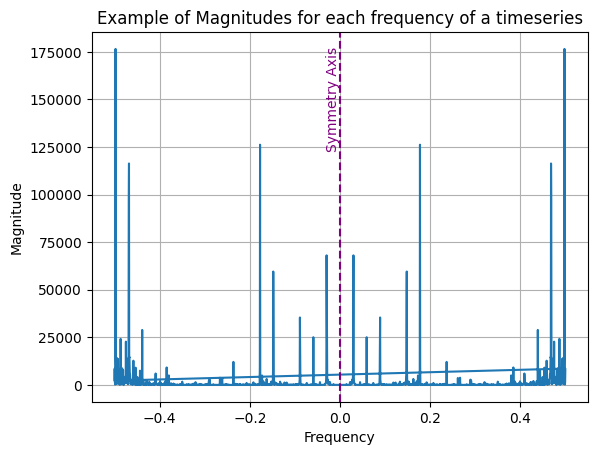

In [3]:
sample_ts= df.iloc[0,5:2053] # take a sample time series
plot_magnitudes(sample_ts)

Thus our first approach involves switching from time space to frequency space using the Fast Fourier Transform.

In our case we therefore choose, despite the fact that the temporal extent of the individual timeseries is **unknown**, to evaluate the power spectrum and for the first half of the frequencies and extract features in the following way:
1. calculate the power spectrum by means of the **fourier transform**;
2. take only the real part of the power spectrum (applying abs);
3. do the square of the magnitudes;
4. divide the frequency axis (x-axis) into bins;
5. for each bin take the maximum power spectrum (magnitude).

This will be the output of the function we are going to use for the extraction of this features

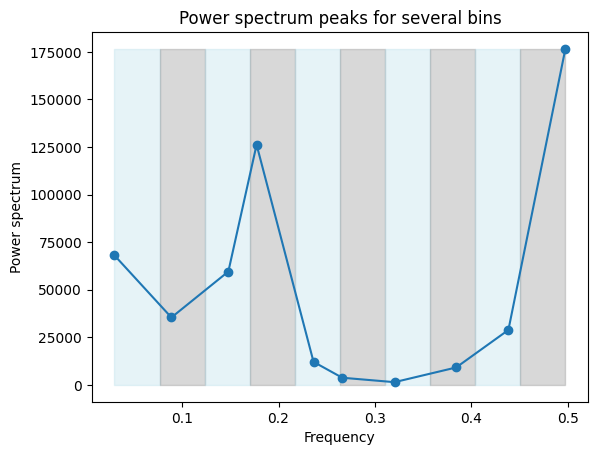

In [4]:
plot_peaks(sample_ts)

### Power spectral density

Power spectral density (PSD) shows how the power of a signal is distributed over frequencies. Periodograms are a particular version of PSDs applied for discrete-time signals and we are going to use them to evaluate our PSD. We decide to extract 3 main summaries form this distribution since seems to be important for tasks related to anomaly detection and vibration/accelerometer analysis:
1. median of the PSD;
2. mean absolute deviation (generally nice in combo with the median);
3. skewness of the PSD.

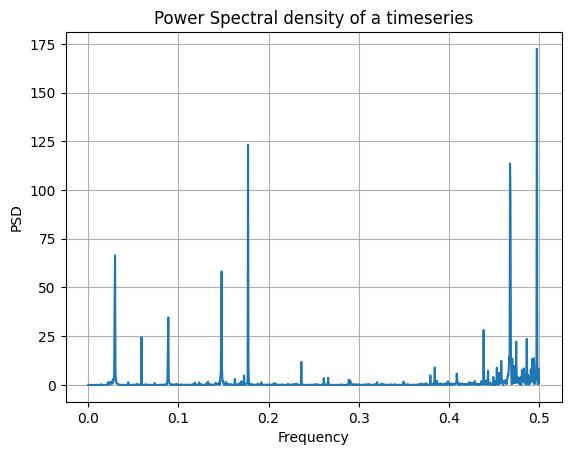

In [5]:
plot_psd(sample_ts)

### Autocorrelation for different lags

The autocorrelation function (ACF) is a mathematical tool used to measure the correlation between a time series and its lagged versions. In simpler terms, it quantifies the similarity between a signal and a delayed copy of itself at different time lags. It is commonly used in signal processing, time series analysis, and statistics.

Mathematically, the autocorrelation function for a time series $\{X(t)\}$ at lag k is defined as:

$$ACF(k) = Cov(X(t), X(t-k)) / (Var(X(t)) * Var(X(t-k)))$$

Where $Cov(X(t), X(t-k))$ is the covariance between $X(t)$ and $X(t-k)$, and $Var(X(t))$ and $Var(X(t-k))$ are the variances of $X(t)$ and $X(t-k)$, respectively.

The ACF provides insights into the temporal patterns and dependencies present in a time series. By examining the ACF plot, you can identify whether the time series exhibits any repeating patterns or significant correlations at different lags. For example:

1. If the ACF decays quickly, it suggests that the time series is relatively random and uncorrelated over longer time lags.
2. If the ACF has a slow decay or periodic spikes, it indicates the presence of seasonality or repeating patterns in the time series.
3. If there is a significant spike in the ACF at a particular lag, it may indicate a strong correlation or relationship between the signal and its past values at that specific time lag.


Now, let's discuss the usefulness of the autocorrelation function in the context of accelerometer signals for anomaly detection.

Accelerometer signals, which measure the acceleration of an object or device, are often used to track and monitor movement or vibrations.  The ACF can be valuable in this context for the following reasons:

>- Revealing Periodic Patterns: Accelerometer data from certain activities or healthy machinery may exhibit periodic patterns. By examining the ACF, you can detect the presence of periodicities and use them to understand normal behavior.

>- Characterizing Cyclic Anomalies: Anomalies in accelerometer data might manifest as cyclic or repeating patterns. ACF can help identify these cyclic patterns, allowing for the detection of regular anomalies.

>- Lag Analysis: The ACF provides information about the correlation between the current and past values of the accelerometer signal. This analysis can be beneficial in understanding the temporal behavior of the system and detecting deviations from the norm.

>- Identifying Unusual Behavior: Sudden changes or unexpected behaviors in accelerometer data might cause spikes or distinct patterns in the ACF. Monitoring the ACF can, therefore, assist in identifying such anomalies.

>- Windowed ACF for Local Anomaly Detection: By computing the ACF within smaller windows of the time series, you can perform local anomaly detection. Sudden changes in ACF values within specific time segments might indicate localized anomalies.

### Other functions for pre-processing

We also planned to introduce other features in addition to those described above:
>- Season: extracted from the "when" column of the original data set, inidicates the season in which the measurement is taken;
>- Elapsed time: again extracted from the "when" column and indicates the number of months passed since the first month of observation.

# Data preparation and feature extraction (high dimensionality)

In [6]:
train = preproc(df)
test = preproc(test_df)

In [7]:
train

,Season,elapsed_time,E1A_mag_max_1,E1A_mag_max_2,E1A_mag_max_3,E1A_mag_max_4,E1A_mag_max_5,E1A_mag_max_6,E1A_mag_max_7,E1A_mag_max_8,...,M2A_psd3,M2H_psd1,M2H_psd2,M2H_psd3,M2P_psd1,M2P_psd2,M2P_psd3,M2V_psd1,M2V_psd2,M2V_psd3
0,2,5,6.806409e+04,35431.749770,59566.427102,126189.729664,12104.302024,3776.425253,1448.342098,9170.837140,...,28.452744,0.014132,0.234603,17.168458,0.014573,0.138001,16.675335,0.001447,0.033303,18.282919
1,3,20,1.848728e+05,438472.069986,289591.035635,3308.291517,74843.101888,3554.999695,820.542539,753.311788,...,15.837722,0.030442,0.209081,10.461992,0.020580,0.042926,5.746151,0.006826,0.115922,11.918044
2,3,70,2.024669e+06,120144.625912,112000.320858,9512.858234,2416.209026,1622.871783,191.321927,526.334264,...,17.891314,0.018397,0.215008,14.345343,0.009525,0.027912,19.951229,0.006381,0.123472,18.462069
3,1,75,1.164122e+04,130062.023086,63264.266551,385363.951843,476220.035156,16840.280143,2786.596621,4081.567101,...,14.283665,0.003277,0.276258,21.956153,0.002684,0.072033,21.260119,0.001413,0.051685,12.570201
4,1,3,1.802098e+04,3651.080879,7153.671289,312.323450,7273.230036,2188.072980,2503.623617,13942.681254,...,20.518775,0.003907,0.061459,10.524084,0.000808,0.011370,13.955317,0.000887,0.022850,15.773869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,1,26,1.284998e+04,122735.369697,24384.588125,192115.450712,67962.611661,3253.077441,3705.208570,7864.876906,...,15.713019,0.004645,0.179328,8.688547,0.004834,0.081339,13.658737,0.002488,0.038790,13.614371
659,1,64,4.150732e+03,128007.904321,20370.578567,8427.957587,155044.450928,33908.927987,682.468216,2403.339912,...,29.274844,0.008489,0.064193,21.850531,0.006127,0.026331,19.125511,0.002126,0.072776,30.545321
660,1,15,1.028444e+04,111601.814605,197658.285183,343008.269175,227935.699029,74277.886723,4596.550570,24059.226406,...,10.944851,0.029701,0.157739,16.822093,0.019558,0.084415,9.870443,0.005622,0.146952,13.225888
661,4,0,4.084544e+05,302934.847480,10649.072514,18817.172722,68414.811460,127692.209605,13454.285278,16568.799289,...,29.468620,0.009112,0.355042,12.764579,0.006090,0.115611,17.350777,0.002193,0.133941,31.157023


### Import the dataset of correlations

We thought of evaluating time series correlations between different measurement points on the compressor. To do this we reused the procedure developed in the second homework as well, only this time we have 3 classes and not 2. We need to build a unique dataset for each class by putting the time series as rows. In this way our new datasets will have as number of rows the absolute frequencies of the class for the length of the time series and as columns 24, which is the number of different points of measuraments. In addition, we constructed 3 other datasets in which the 2 different classes than the reference class are present, changing the re-reference class each time. Then in this way we created the graphs of the differences between the correlations of the reference class versus the correlation of the other two classes put together, in a kind of one vs all approach, so as to see if there are relevant differences in the correlations between two point in that class versus the other. This procedure was done for each class, and once a certain threshold was used, we selected the common variables. To take advantage of the code previously we worked on R and exported the 21 variables, these are the correlations that show a greater difference in one class than the others and could be useful for classification.

In [32]:
corr_train=pd.read_csv("train_a.csv")
corr_test=pd.read_csv("test_b.csv")

In [33]:
train=pd.concat([train,corr_train],axis=1)
test=pd.concat([test,corr_test], axis=1)

# Scaling the data set

We note that groups of columns have different sizes so we opt for (robust) standardization by columns in our dataframe in order to make the different features comparable and not get strange values for the parameters of our model. It is particularly useful when working with data that contain outliers or scattered values and it's computed as following:

$$
X_{\text {scale }}=\frac{x_i-x_{\mathrm{med}}}{x_{75}-x_{25}}
$$

In [34]:
#Scale data with RobustScaler 
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
col=train.columns
X_tr_scaled = pd.DataFrame(scaler.fit_transform(train),columns=col)
X_te_scaled = pd.DataFrame(scaler.fit_transform(test),columns=col )
X_te_scaled

,Season,elapsed_time,E1A_mag_max_1,E1A_mag_max_2,E1A_mag_max_3,E1A_mag_max_4,E1A_mag_max_5,E1A_mag_max_6,E1A_mag_max_7,E1A_mag_max_8,...,cor_E2P_M2P,cor_E3P_E4P,cor_E3P_M1P,cor_E3P_M2P,cor_E3V_E4A,cor_E3V_E4V,cor_E4A_E4H,cor_E4P_M2P,cor_M1A_M2A,cor_M1P_M2P
0,1.0,0.638298,-0.053077,-0.262788,0.047737,-0.242141,-0.169405,-0.221405,-0.215468,-0.232382,...,-0.511122,-0.254089,0.096485,-0.548342,1.769077,0.091947,0.726240,-0.476365,0.001820,-1.332654
1,-0.5,0.680851,-0.072831,-0.266944,-0.349170,-0.152923,0.557963,8.095217,-0.112630,0.505699,...,0.612548,-0.220519,-1.113509,0.697665,2.088551,0.484775,-0.262615,0.257704,-0.460445,-0.224991
2,0.5,-0.446809,-0.075265,-0.297735,-0.293777,-0.248054,-0.185424,-0.242364,-0.142257,-0.231727,...,0.368787,-1.128125,1.083483,0.035716,-1.100787,0.939328,-0.343666,-0.026715,1.450220,1.111149
3,0.0,-0.510638,1.175205,5.244658,1.275429,-0.107898,-0.147076,-0.226465,-0.013965,0.314038,...,-0.325875,0.109699,-0.365506,0.646366,-0.360070,-0.081909,0.473251,-0.663408,0.628869,0.306305
4,0.5,-0.723404,0.022613,-0.264118,0.000000,3.791340,0.145261,0.105445,0.639288,1.300892,...,0.145265,1.123927,1.092905,-0.500491,-0.594256,-0.421169,0.091400,-0.547371,0.011724,0.607256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,0.0,-0.531915,1.234051,0.124932,2.840187,0.594311,-0.155921,0.063501,10.464636,10.876975,...,-1.035705,1.533840,-0.187597,-0.153438,0.215660,-1.240892,-0.280268,0.154121,0.502359,-0.038427
351,0.5,0.340426,3.358659,2.366177,0.709307,1.397244,0.219068,-0.012056,-0.058571,0.171578,...,-0.095510,-0.878416,0.240232,-0.070995,0.064262,0.338604,-0.749398,0.023011,0.107523,0.435311
352,-0.5,0.468085,-0.008211,-0.313141,-0.413022,-0.283238,-0.184331,-0.232822,-0.210426,-0.219666,...,0.221995,0.064987,0.245384,-1.329974,-2.078832,-0.821568,-0.608044,-0.649634,-0.128411,4.613754
353,0.0,0.531915,1.188247,2.389373,0.340484,1.075466,1.630573,4.197880,8.086532,24.843820,...,0.062246,-0.158405,0.518511,0.206861,-0.119173,-0.592147,-0.076729,-0.796327,-0.379058,0.321494


# Dimensionality reduction with PCA (failed)

Dimensionality Reduction with PCA (linear)\

In order to reduce our high dimensionality data with all the features extracted:
- Peaks of magnitudes at LHC compressors low frequencies;
- Autocorrelations among time series;
- correlations one versus all.

We tried to reduce the high dimensionality through a pincipal components analysis. PCA practically is a linear transformation of the variables that projects the original variables into a new Cartesian system in which the new variable with the highest variance is projected onto the first axis, the new variable, second in variance size, onto the second axis, and so on.
We have tried to focus the reduction on the explained variance of the components, paying the price of lost information about specific columns (specific peaks of power spectrum for example.)

In [ ]:
# Let's fit PCA
pca = PCA().fit(X_tr_scaled)
# display the percentage of total variance explained by each principal component#
print(pca.explained_variance_ratio_.shape)

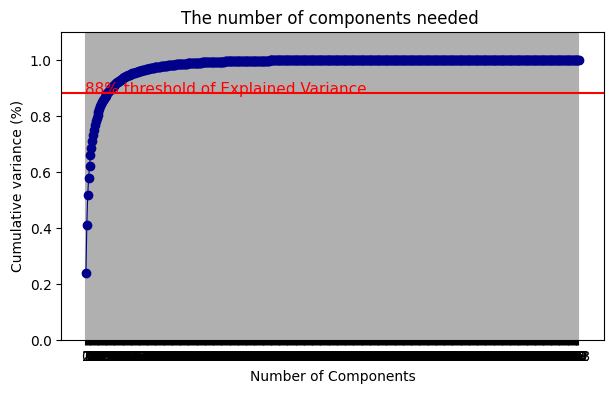        .   .     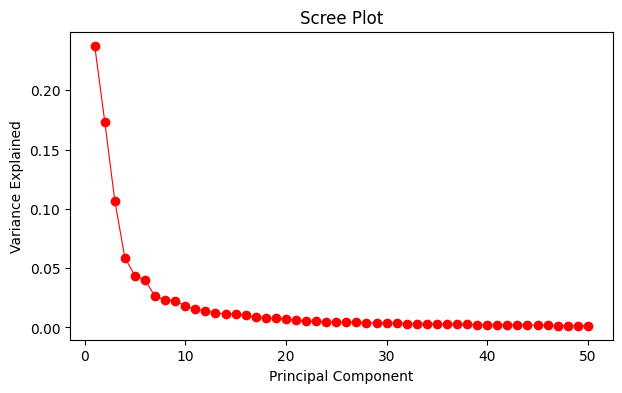

The plots above shows the cumulative variance increasing the number of principal components generated by PCA procedure.
Running our algorithms we noticed that, using principal component data on our classification algorithms the performances becomes worse. This may be due to the fact that during the process of dimensionality reduction, PCA may result in the loss of detailed information on individual columns of the original data. This happens because PCA operates on the basis of data variance and tries to reduce complexity by retaining only the most relevant information. The principal components identified by PCA are linear combinations of the original columns, so some column-specific information may be merged together or even eliminated in the projection process./
Due to this we decided to do not implement a PCA and use a model agnostic ***Permutation Importance*** procedure (as described in Elements of SL,chapter "15.3.2 Variable Importance") to filter our data and select the most important features

# Resampling with SMOTE

The data we are dealing with are strongly unbalanced with regard to the classes to be classified:

Label 1: 0.935143% of data;\
Label 2: 0.058824;\
Label 3: 0.006033.

To overcame this issue we have tried to use a SMOTE tecnique of over/under sampling.\
Please furthermore notice that, after a data exploration we noticed that:



In [17]:
df[df.y==3]

,id,main.pos,fun.pos,when,y,E1A1,E1A2,E1A3,E1A4,E1A5,...,M2V2041,M2V2042,M2V2043,M2V2044,M2V2045,M2V2046,M2V2047,M2V2048,Season,elapsed_time
19,29,LHCB-6,QSCB-6-CP7,2018-06-01,3,3.849429,-1.120215,1.900126,1.765498,-3.954946,...,-0.035500,-0.032582,0.158069,0.152430,0.453890,0.563897,0.683447,-0.023237,2,17
332,514,LHCB-6,QSCB-6-CP7,2017-11-01,3,-1.329898,-1.862015,-1.651927,-1.171916,0.036863,...,0.003700,-0.093183,0.167388,0.251590,0.381014,0.320008,0.095782,-0.094574,3,10
568,874,LHCB-6,QSCB-6-CP7,2017-12-01,3,1.988860,0.591283,1.497192,0.372399,1.557347,...,0.296484,0.025949,-0.071119,-0.088406,0.046136,-0.029481,0.014090,-0.267449,4,11
575,885,LHCB-8,QSCB-8-CP1,2020-10-01,3,-0.685269,0.234567,-0.149447,-0.076372,-0.050782,...,0.053421,0.123710,0.063862,0.047044,0.082810,-0.020352,0.063948,0.054148,3,45


three maximum alert level (label 3) have been detected by the same main position of sensors in the LHC. Generally LHCB main position seems to be a high risk position for "Big fail" alert level.

In [36]:
def resampling_strategy(train, y):
    counts = y.value_counts()
    total_new_train = int(np.ceil(counts[1]*100/70))
    sampling_strategy={2: int(np.ceil(total_new_train*0.25)), 3: int(np.floor(total_new_train*0.05))}
    return sampling_strategy

#smote = SMOTE(sampling_strategy=resampling_strategy(principalDf, df.y), k_neighbors=3)
smote = SMOTE(k_neighbors=3)#sampling_strategy=resampling_strategy(X_tr_scaled, df.y), k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_tr_scaled, df.y)  

# Feature importance

Find Variable Importance using Permutation importance as described in Elememnts Of SL book. Notice that we use a sort of cross validation on the different classifiers and compute the mean of all the importance scores. 

### PERMUTATION IMPORTANCE 

The main idea behind Permutation Importance is to measure how much the predictive performance of a model deteriorates when the values of a particular feature are randomly permuted. The Permutation Importance scores can be used to rank the features based on their importance. Features with higher scores are considered more influential in the model's predictions, while features with lower scores are deemed less important.

In [38]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#PERMUTATION IMPORTANCE WITHout CROSS VALIDATION 
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled,y_train_resampled)
model = LogisticRegression(multi_class='multinomial', class_weight="balanced",max_iter=1000,n_jobs=-1)
lr = model.fit(X_train, y_train-1)

r = permutation_importance(model, X_val, y_val, n_repeats=100, n_jobs=-1, random_state=0)
importance_df = pd.DataFrame()
importance_df["Features"] = X_tr_scaled.columns
importance_df['Importances'] = r.importances_mean


In [45]:
X_tr = X_train_resampled[importance_df[importance_df["Importances"] > 0.0002].Features.values]
X_tr

,E1A_mag_max_6,E1V_mag_max_7,E1V_mag_max_8,E2A_mag_max_11,E2H_mag_max_8,E2V_mag_max_8,E3H_mag_max_10,E3H_mag_max_11,E4A_mag_max_6,E4A_mag_max_7,...,M1H_mag_max_7,M1H_mag_max_8,M1H_mag_max_1,M1H_mag_max_5,M1V_mag_max_10,M2A_mag_max_1,M2H_mag_max_5,M2V_mag_max_4,E2A_psd2,cor_E3V_E4A
0,0.039422,7.020925,15.585273,0.382115,-0.142112,0.661720,0.586508,0.428370,0.619162,-0.105400,...,-0.270466,-0.226682,-0.125634,-0.261951,-0.143528,-0.294740,-0.179505,2.364448,-0.193553,1.120693
1,0.028135,-0.143063,-0.165264,0.108456,0.328507,0.092942,-0.268614,-0.187020,0.395465,-0.034374,...,4.160368,1.524481,1.535556,1.891048,0.309241,0.143925,2.432722,1.347164,-0.133627,-2.388895
2,-0.070351,-0.136579,-0.152090,-0.016347,3.479717,0.120743,-0.440804,-0.403386,-0.185856,0.019921,...,6.321317,3.475789,4.058494,0.089018,-0.067613,0.000568,0.682820,2.251462,0.700701,0.408244
3,0.705323,0.007500,-0.125810,0.395393,0.971524,1.242974,0.269326,0.837783,-0.039785,0.310685,...,-0.217263,-0.294760,-0.148706,-0.207138,-0.142485,0.527448,-0.267823,-0.341132,-0.085938,0.178487
4,-0.041541,6.471077,11.459325,-0.243782,-0.181382,-0.213556,-0.420938,-0.276111,-0.144902,-0.076566,...,-0.277995,-0.314340,0.785985,-0.351034,-0.046554,0.315969,-0.246636,-0.320740,-0.262387,-0.504943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,-0.050005,2.473184,1.160485,2.357049,7.728049,2.770251,0.517038,0.840202,0.118665,0.388926,...,4.755698,1.878494,2.062005,0.915332,0.175444,0.635714,3.011255,1.445486,1.425179,-0.396976
1856,-0.086198,-0.009324,0.205164,-0.036945,1.808775,0.649714,-0.402551,-0.128795,0.200215,0.054089,...,1.590554,0.797462,0.077092,1.304962,-0.011572,2.336294,0.285787,1.717604,0.054950,-0.158217
1857,-0.014505,-0.023813,0.751722,0.261055,4.807867,1.854874,-0.349493,0.098330,0.576282,-0.073375,...,4.287171,2.508887,0.247987,3.884981,0.184465,0.849475,1.114234,4.913256,0.752987,-0.053407
1858,14.627397,1.478908,2.665996,3.101822,1.035617,1.464679,6.111525,7.257406,5.069790,22.357813,...,0.683273,0.065317,0.484813,1.274782,1.905680,2.257431,0.510563,0.445573,2.441543,-0.678621


In [46]:
#no correlation inside the  best features!
X_tr.columns.str.contains("cor").sum()

1

In [110]:
#X_tr.to_pickle("X_56_COLS")

# CV for logistic regression

Cross Validation to choose the best parameters:

In [57]:
#CROSS VALIDATION
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer,confusion_matrix

tol = [1e-4, 3e-4, 1e-3, 5e-4]
fit_intercept = [True, False]
solver= ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
warm_start=[True,False]
n_iter=[100,1000,10000]
penalty = ['l1', 'l2']
C = [ 0.01, 0.1, 1, 10, 100,1000]
hyperparameters = dict(penalty=penalty, C=C,warm_start=warm_start,max_iter=n_iter,solver=solver,tol=tol,fit_intercept=fit_intercept)
#fit the model 
model = LogisticRegression(multi_class='multinomial', max_iter=10000, class_weight="balanced",n_jobs=-1)


def bas(y_true, y_pred):
    num_labels = 3
    #sensitivities = []
    #specificities = []
    recall=[]
    class_counts={1 :(1/0.935143),2:(1/0.058824),3 :(1/0.006033)}

    for i in range(num_labels):
        y_true_label = y_true[:, i]
        y_pred_label = y_pred[:, i]
        
        tn, fp, fn, tp = confusion_matrix(y_true_label, y_pred_label).ravel()
        #sensitivity = tp / (tp + fn)
        #specificity = tn / (tn + fp)
        rec= tp / (tp+fn)*class_counts.values[i]
        
        recall.append(rec)
        #sensitivities.append(sensitivity)
        #specificities.append(specificity)
    
    bas= np.mean(recall)
    #mean_sensitivity = np.mean(sensitivities)
    #mean_specificity = np.mean(specificities)
    
    return bas
    #return 0.5 * (mean_sensitivity + mean_specificity)

bas_scorer = make_scorer(bas)

random_search = RandomizedSearchCV(model, hyperparameters, n_iter=100, cv=StratifiedKFold(n_splits=5), random_state=42, scoring=bas_scorer)
#random_search.fit(X_train_resampled, y_train_resampled)
random_search.fit(X_tr, y_train_resampled)
best_params=random_search.best_params_
print("Best parameters:", random_search.best_params_) 




c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_9248\2198874025.py", line 26, in bas
    y_true_label = y_true[:, i]
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python3

In [ ]:
cols=X_tr.columns.to_list()
X_te = X_te_scaled[cols]

In [ ]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_te)
y_pred

array([2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 2, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 3, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 2, 2, 3, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, 2, 2,
       1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 3, 1, 1, 1, 1, 3, 1, 1, 2, 2, 2, 3, 1, 2, 1, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 3, 2, 1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1,

# Logistic Regression with weights

In [332]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2)

# Define the class weights inversely proportional to their frequencies
#weights = {"1": 1 / 620, "2": 1 / 39, "3": 1 / 4}

# Create an instance of LogisticRegression for multinomial classification
model = LogisticRegression(multi_class='multinomial', class_weight="balanced",**best_params)

# Train the logistic regression model
model.fit(X_train, (y_train)-1)

# Predict the target variable for the test set
preds = model.predict(X_test)
predictions= (preds)+1

# Evaluate the model
classification_report = classification_report(y_test, predictions)
print(classification_report)



              precision    recall  f1-score   support

           1       0.83      0.69      0.75       116
           2       0.58      0.68      0.62        56
           3       0.38      1.00      0.55         6

    accuracy                           0.70       178
   macro avg       0.59      0.79      0.64       178
weighted avg       0.74      0.70      0.71       178



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [333]:
predictions=model.predict(X_te)
predictions= (predictions)+1
preditctions

array([1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 3, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 3, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1,
       1, 2, 2, 1, 2, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2,
       1, 1, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       1, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 3,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 3,

# Consegna

In [53]:
def consegna(pretictions, i):
    """
    predictions: array-like set of predictions from our model
    i: int representing the number of the output we are uploading
    """
    out = pd.DataFrame({"id": test_df["id"], "y": pretictions})
    out.to_csv(f'output{i}.csv', index=False)

In [55]:
consegna(y_pred,"_IMPORTANT_NONIMMACOLATO")